# Counting Dummy Targets

This section is meant to be used to see how much faster it is with GPU, roughly.

As it turns out, it is about twice as fast for the 90 images. ~3.5 to 4 min to count through the 90 images with 2 sets of exemplars using colab GPU. While it takes about 8 with my laptop CPU

In [1]:
%load_ext autoreload
%autoreload 2

root_path = '/content/drive/MyDrive/ECE MEng Courses/ECE2500/LearningToCountEverything'
from google.colab import drive
drive.mount('/content/drive')
import sys
from pathlib import Path
sys.path.append(root_path)
%cd '/content/drive/MyDrive/ECE MEng Courses/ECE2500/LearningToCountEverything'

Mounted at /content/drive
/content/drive/MyDrive/ECE MEng Courses/ECE2500/LearningToCountEverything


In [2]:
from BubbleCount.counting_model import CountingPipe
import BubbleCount.image_preprocess as image_preprocess
from BubbleCount.post_processing import get_normalized_mse
import os
import datetime

In [13]:
# Counting with either the adjusted or unadjusted exemplars

""" The the experiment, the counting of adjusted and unadjusted were first conducted
    with num_boxes=4, which is using 4 exemplars from each sample image. Then, the
    counting of unadjusted is done with num_boxes=6
"""

print(f"Starting at: {datetime.datetime.now()}")


pipe = CountingPipe(num_boxes=6)  # Initiate the folder paths with `args` if need
# pipe.pre_pipe()
# pipe.counting_all_batches()     # Make sure the exemplar images are in the dedicated subfolders under /Exemplars
# pipe.counting_all_unadjusted()  # Make sure the exemplar images are in the /Exemplars, as the pipeline disregards what's in the subfolders
# pipe.clean_up()


print(f"Finished at: {datetime.datetime.now()}")

Starting at: 2023-11-22 17:35:32.210322
===> Using CPU mode.

Finished at: 2023-11-22 17:35:32.220516


# Processing Results

There are two exemplars used for now. There are 9 batches of targets. Each batch can be defined by the serial number such as "SEN06_1.2_1_000-100".

The main goal of this section is to properly order the data and analyze the quality of the model counted results, above, and the manually counted, below.

## Part 0 - Loading Stuff

In [15]:
import csv
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from BubbleCount.post_processing import get_normalized_mse
%matplotlib inline

In [17]:
result_path_adj = "Outputs/Output_adjusted.csv"
df_adj = pd.read_csv(result_path_adj, header=0)

result_path_unadj = "Outputs/Output_unadjusted.csv"
df_unadj = pd.read_csv(result_path_unadj, header=0)

result_path_set6 = "Outputs/Output_unadjusted_set6.csv"
df_set6 = pd.read_csv(result_path_set6)

In [18]:
print(df_adj.head())
print(df_unadj.head())
print(df_set6.head())

  Exemplar                                             Target  bubble counts
0   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000004_c...      17.123608
1   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000001_c...      18.348644
2   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000002_c...      17.995039
3   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000000_c...      17.453785
4   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000006_c...      22.252501
  Exemplar                                             Target  bubble counts
0   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000004_c...      17.624695
1   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000001_c...      18.765196
2   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000002_c...      18.095247
3   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000000_c...      17.111538
4   exemp1  04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000006_c...      23.293201
  Exemplar                                             Target       Count
0 

In [19]:
result_path_manual = "Targets/Targets_dummy_manualCount/manual_counts.xlsx"
df_manual = pd.read_excel(result_path_manual)
df_manual.head()

,Image,Counts
0,04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000000_c...,18
1,04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000001_c...,15
2,04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000002_c...,18
3,04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000003_c...,17
4,04-25-23_SEN06_1.2_1_000-100.7dk9xc26.000004_c...,13


In [20]:
# Helper function for breaking down the image names
def get_batch_and_serial(target):
    temp = target.split('_')[1:-1]
    temp = '_'.join(temp)
    serial_number = temp.split('.')[-1]
    batch_name = '.'.join(temp.split('.')[0:-2])

    # print(f'batch name: {batch_name}. Number: {serial_number}')
    return batch_name, int(serial_number)

## Part 1 - Reordering Results to DataFrame

Creating new columns for batch and serial number by breaking down the image name

In [21]:
def reorder_pipe(df):
    """Sorting the df"""
    df = add_batch_serial_cols(df)
    headers = df.columns.tolist()
    if 'Exemplar' in headers:
        df = df.sort_values(by=['Exemplar', 'batch', 'serial_num'])
    else:
        df = df.sort_values(by=['batch', 'serial_num'])
    df = df.reset_index(drop=True)
    return df

def add_batch_serial_cols(df):
    """Create two new columns for batch name and serial number"""
    headers = df.columns.tolist()
    image_name = ""
    if "Target" in headers:
        image_name = "Target"
    elif "Image" in headers:
        image_name = "Image"

    df[['batch', 'serial_num']] = df[image_name].apply(lambda x: pd.Series(get_batch_and_serial(x)))

    # Constructing the new columns
    idx = headers.index(image_name)
    headers.pop(idx)
    headers.insert(idx, 'batch')
    headers.insert(idx+1, 'serial_num')

    df = df[headers]

    return df

In [22]:
df_adj = reorder_pipe(df_adj)
df_unadj = reorder_pipe(df_unadj)
df_set6 = reorder_pipe(df_set6)
df_manual = reorder_pipe(df_manual)

In [23]:
print("Adjusted:")
print(df_adj.head(2))
print("Unadjusted:")
print(df_unadj.head(2))
print("Set of 6 exemplars:")
print(df_set6.head(2))
print("Manual Counts")
print(df_manual.head(2))

Adjusted:
  Exemplar                batch  serial_num  bubble counts
0   exemp1  SEN06_1.2_1_000-100           0      17.453785
1   exemp1  SEN06_1.2_1_000-100           1      18.348644
Unadjusted:
  Exemplar                batch  serial_num  bubble counts
0   exemp1  SEN06_1.2_1_000-100           0      17.111538
1   exemp1  SEN06_1.2_1_000-100           1      18.765196
Set of 6 exemplars:
  Exemplar                batch  serial_num     Count
0   exemp1  SEN06_1.2_1_000-100           0  5.745326
1   exemp1  SEN06_1.2_1_000-100           1  6.301402
Manual Counts
                 batch  serial_num  Counts
0  SEN06_1.2_1_000-100           0      18
1  SEN06_1.2_1_000-100           1      15


In [24]:
print("Quick order check of the data sets")

if df_adj[['batch', 'serial_num']].equals(df_unadj[['batch', 'serial_num']]):
    print("OK: The two model counts have the same images and order.")
else:
    print("NO GOOD: The two model counts are not so much the same")

b_same = True
for i in range (df_manual.shape[0]):
    if df_adj['batch'][i] != df_manual['batch'][i]:
        print(f"Not the same batch at row: {i}")
        print(f"adj: {df_adj['batch'][i]}")
        print(f"manual: {df_manual['batch'][i]}")
        b_same = False

    if df_adj['serial_num'][i] != df_manual['serial_num'][i]:
        print(f"Not the same serial_num at row: {i}")
        print(f"adj: {df_adj['serial_num'][i]}")
        print(f"manual: {df_manual['serial_num'][i]}")
        b_same = False
if b_same:
    print("OK: The model counts are in the same order as the manual counts.")


Quick order check of the data sets
OK: The two model counts have the same images and order.
OK: The model counts are in the same order as the manual counts.


## Part 2 - Some Plots
Dealing with 3 sets of data: adjusted model counts, unadjusted model counts, and manual counts. Two of these can be categorized as model counts.

### 2.1 Start with the all batch graphs

Overview of counting results for both model counts and manual counts

In [ ]:
# Merging df_adj, df_unadj, and df_set6

df_model = pd.merge(df_adj, df_unadj, on=['Exemplar', 'batch', 'serial_num'], suffixes=('_adj', '_unadj'))
df_model = pd.merge(df_model, df_set6, on=['Exemplar', 'batch', 'serial_num'])
df_model = df_model.rename(columns={'bubble counts_adj': 'counts_adj',
                                    'bubble counts_unadj': 'counts_unadj',
                                    'Count': "counts_set6"})

df_model.head()

,Exemplar,batch,serial_num,counts_adj,counts_unadj,counts_set6
0,exemp1,SEN06_1.2_1_000-100,0,17.453785,17.111538,5.745326
1,exemp1,SEN06_1.2_1_000-100,1,18.348644,18.765196,6.301402
2,exemp1,SEN06_1.2_1_000-100,2,17.995039,18.095247,6.201206
3,exemp1,SEN06_1.2_1_000-100,3,14.698973,15.033589,4.294728
4,exemp1,SEN06_1.2_1_000-100,4,17.123608,17.624695,5.394546


In [ ]:
def plot_all_batch_w_model(df):
    # Including two exemplars
    exemplar_1_data = df[df['Exemplar'] == 'exemp1']
    exemplar_2_data = df[df['Exemplar'] == 'exemp2']

    for count_header in ['counts_adj', 'counts_unadj', 'counts_set6']:
        plt.figure(figsize=(10, 6))
        plt.plot(exemplar_1_data.index, exemplar_1_data[count_header], label='Exemplar 1')
        plt.plot(exemplar_2_data.index - 91, exemplar_2_data[count_header], label='Exemplar 2')


        plt.xlabel('Images')
        plt.ylabel('Counts')
        plt.title(f'Counting Results with {count_header} Exemplars')
        plt.grid(True)

        for i in range(0, len(exemplar_1_data), 10):
            if i // 10 % 2 == 0:
                plt.axvspan(i, i + 10, facecolor='lightgray', alpha=0.5)
            else:
                plt.axvspan(i, i + 10, facecolor='white')

        plt.xlim(0, 90)
        plt.legend()
        plt.show()

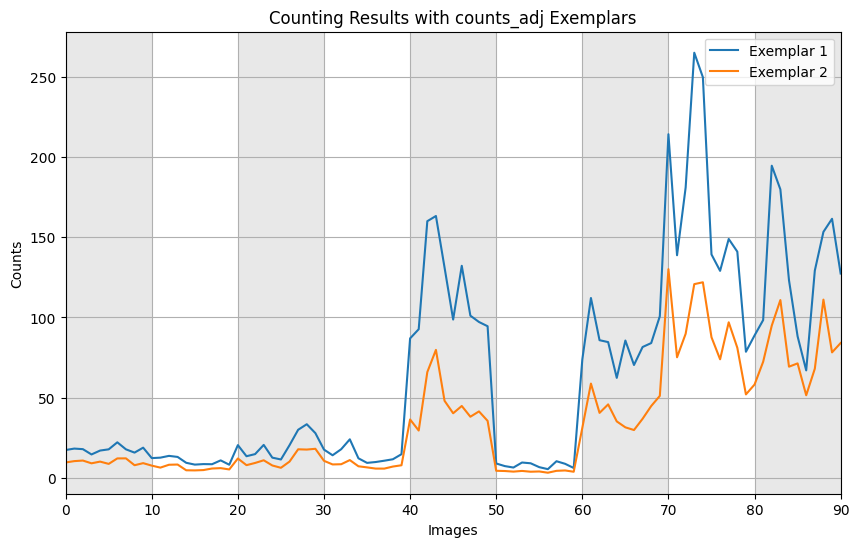

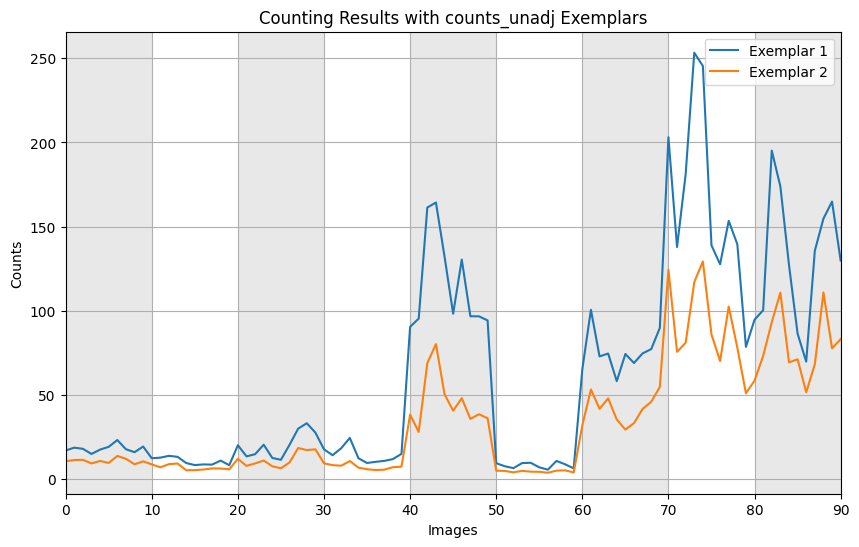

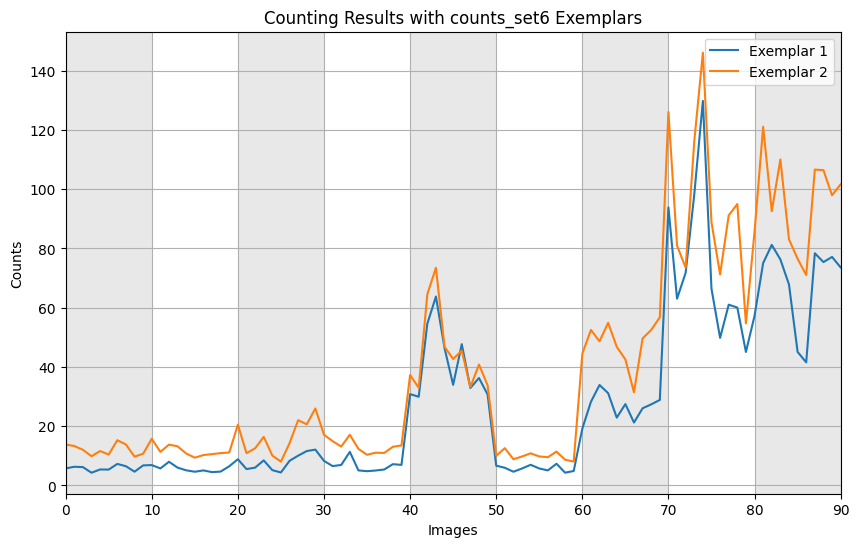

In [ ]:
plot_all_batch_w_model(df_model)

Overall, the adjusted and unadjusted produces very similar results. The difference of using brightness adjustment is not overly significant. Will be further investigated.
Note that the exemplar 2 counts are consistently less than thoes from exemplar 1. This is expected based on previous conclusions from "Counting_Quality_Exp.ipynb"

As for the third graph, the 6 exemplars from Sample image 2 seems to be more reliable. While, overall, the bias seems to be consistent still.

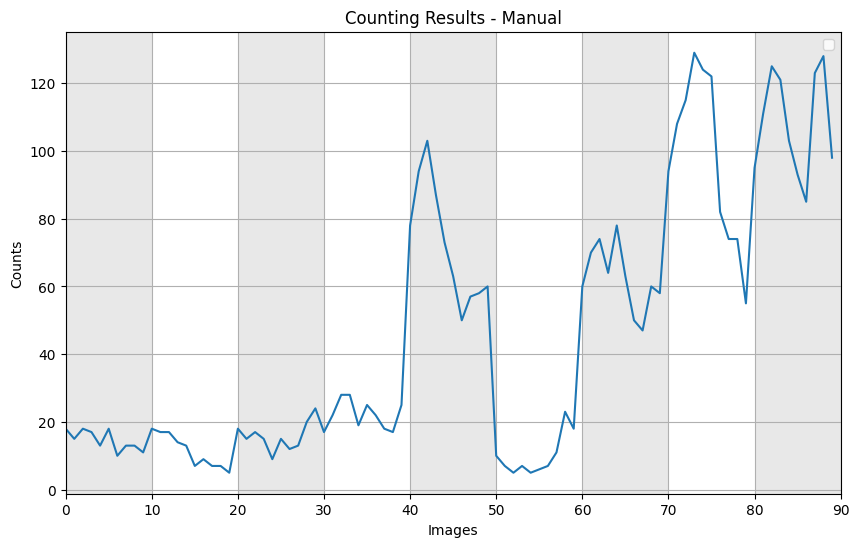

In [ ]:
def plot_all_batch_manual(df):

    plt.figure(figsize=(10, 6))
    plt.plot(df['Counts'])

    plt.xlabel('Images')
    plt.ylabel('Counts')
    plt.title(f'Counting Results - Manual')
    plt.grid(True)

    for i in range(0, df.shape[0], 10):
        if i // 10 % 2 == 0:
            plt.axvspan(i, i + 10, facecolor='lightgray', alpha=0.5)
        else:
            plt.axvspan(i, i + 10, facecolor='white')

    plt.xlim(0, 90)
    plt.legend()
    plt.show()

plot_all_batch_manual(df_manual)

Just from above three graphs, seems like the model counts and manual counts have a similar trend.

### 2.2 Adjusted vs. Unadjusted

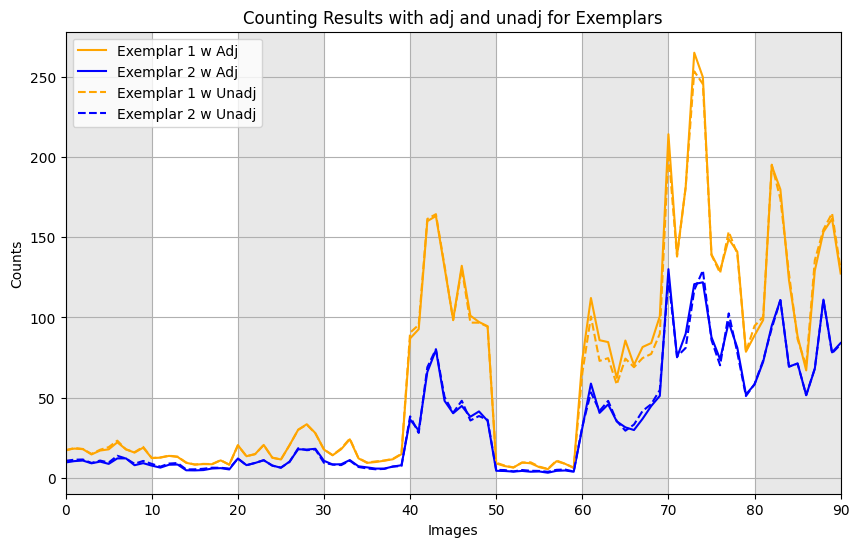

In [ ]:
# Ploting adjusted and unadjusted together

# Including two exemplars
exemplar_1 = df_model[df_model['Exemplar'] == 'exemp1']
exemplar_2 = df_model[df_model['Exemplar'] == 'exemp2']

plt.figure(figsize=(10, 6))
plt.plot(exemplar_1.index, exemplar_1['counts_adj'], label='Exemplar 1 w Adj', color='orange', linestyle='-')
plt.plot(exemplar_2.index - 91, exemplar_2['counts_adj'], label='Exemplar 2 w Adj', color='blue', linestyle='-')
plt.plot(exemplar_1.index, exemplar_1['counts_unadj'], label='Exemplar 1 w Unadj', color='orange', linestyle='--')
plt.plot(exemplar_2.index - 91, exemplar_2['counts_unadj'], label='Exemplar 2 w Unadj', color='blue', linestyle='--')


plt.xlabel('Images')
plt.ylabel('Counts')
plt.title(f'Counting Results with adj and unadj for Exemplars')
plt.grid(True)

for i in range(0, len(exemplar_1), 10):
    if i // 10 % 2 == 0:
        plt.axvspan(i, i + 10, facecolor='lightgray', alpha=0.5)
    else:
        plt.axvspan(i, i + 10, facecolor='white')

plt.xlim(0, 90)
plt.legend()
plt.show()

Visually, the results from adjusted and unadjusted exemplars are very close. The batch that has the most discrepencies is the 7th, which is the `SEN9_1.8_1_000-100.77rnm0bm`

Trying to find out which batches are more different.

#### 2.2.1Plotting the counts batch by batch, exemplar by exemplar
And also calculating the normalized MSE as a metric for comparing the differences across the batch.

In [ ]:
# Calculate the square error for future plotting
df_model['sq_error'] = (df_model['counts_adj'] - df_model['counts_unadj'])**2
df_model.head()

,Exemplar,batch,serial_num,counts_adj,counts_unadj,counts_set6,sq_error
0,exemp1,SEN06_1.2_1_000-100,0,17.453785,17.111538,5.745326,0.117133
1,exemp1,SEN06_1.2_1_000-100,1,18.348644,18.765196,6.301402,0.173515
2,exemp1,SEN06_1.2_1_000-100,2,17.995039,18.095247,6.201206,0.010042
3,exemp1,SEN06_1.2_1_000-100,3,14.698973,15.033589,4.294728,0.111968
4,exemp1,SEN06_1.2_1_000-100,4,17.123608,17.624695,5.394546,0.251088


In [ ]:
"""SS with Bar charts instead"""


# df_model_grouped = df_model.groupby(['Exemplar','batch'])

# batches = pd.unique(df_model['batch'])
# exemplars = pd.unique(df_model['Exemplar'])
# COLOURS = {"exemp1": "orange", "exemp2": "blue"}

# norm_mse = {}

# for exem in exemplars:
#     norm_mse[exem] = {}
#     fig, axes = plt.subplots(3, 3, figsize=(15, 10))
#     for i, batch in enumerate(batches):
#         row = i // 3
#         col = i % 3

#         batch_data = df_model_grouped.get_group((exem, batch))
#         ax = axes[row, col]

#         ax.plot(batch_data['serial_num'], batch_data['counts_adj'], label='Adjusted', color=COLOURS[exem], linestyle="-")
#         ax.plot(batch_data['serial_num'], batch_data['counts_unadj'], label='Unadjusted', color=COLOURS[exem], linestyle='--')

#         adj_mean = batch_data['counts_adj'].mean()
#         unadj_mean = batch_data['counts_unadj'].mean()
#         mean_diff = abs(adj_mean - unadj_mean)
#         # Calculating the normalized MSE. Normalize by dividing squared mean
#         batch_mse = (batch_data['sq_error'].sum() / adj_mean**2) * (1/batch_data.shape[0])
#         # Save the Normalized MSE
#         norm_mse[exem][batch] = batch_mse

#         # Percentage mean difference
#         # ax.annotate(f'% mean difference: {mean_diff*100:.1f}%', xy=(0.02, 0.9), xycoords='axes fraction')
#         ax.annotate(f'Mean difference: {mean_diff:.1f}', xy=(0.02, 0.9), xycoords='axes fraction')

#         ax.set_title(f"{batch} with {exem}")
#         ax.set_xticks([])
#         ax.set_xticklabels([])

#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper right')
#     fig.suptitle(f"Batch counts with {exem}", fontsize=16)
#     plt.show()

'SS with Bar charts instead'

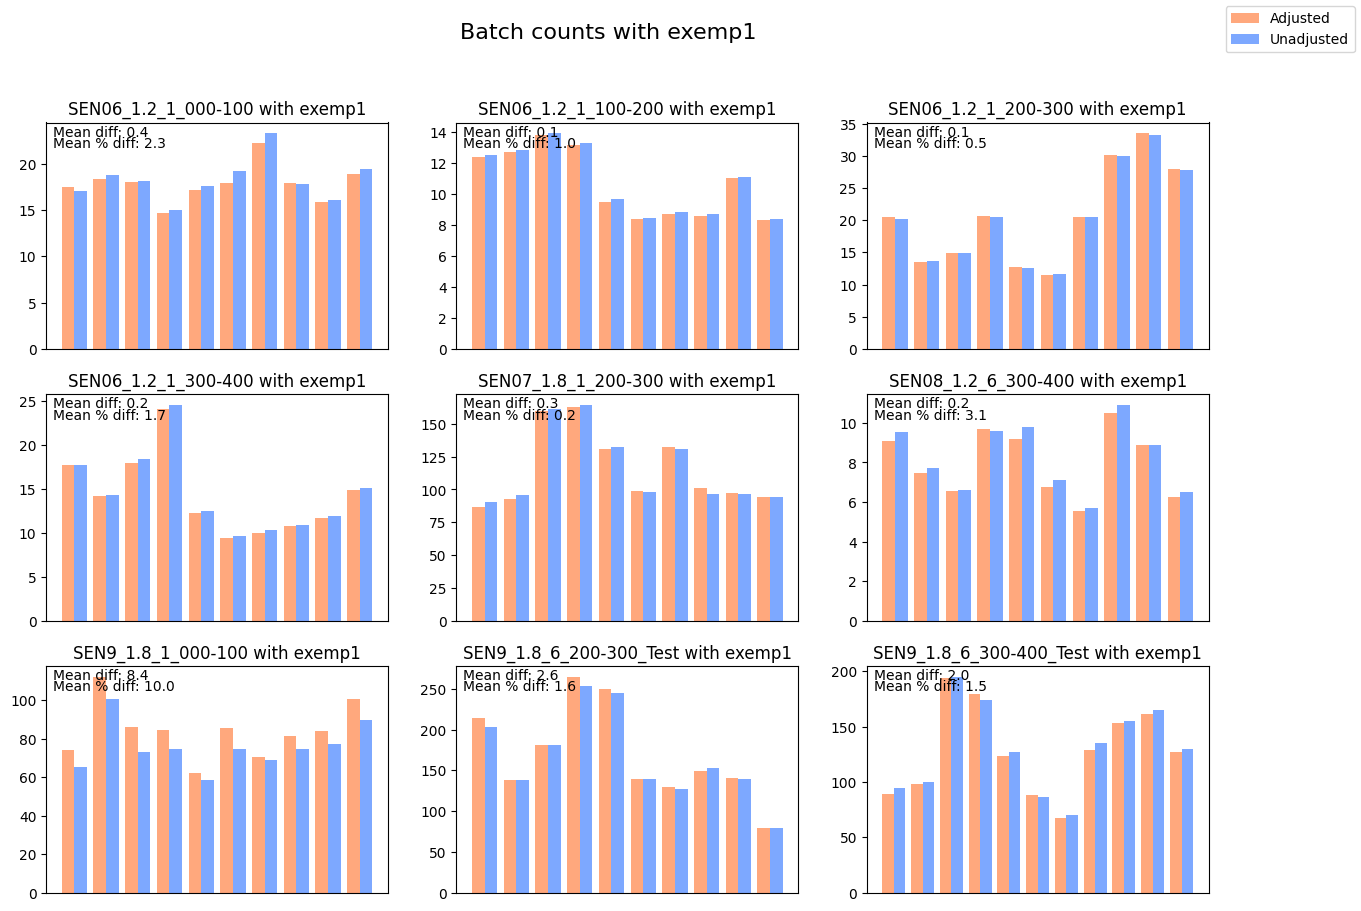

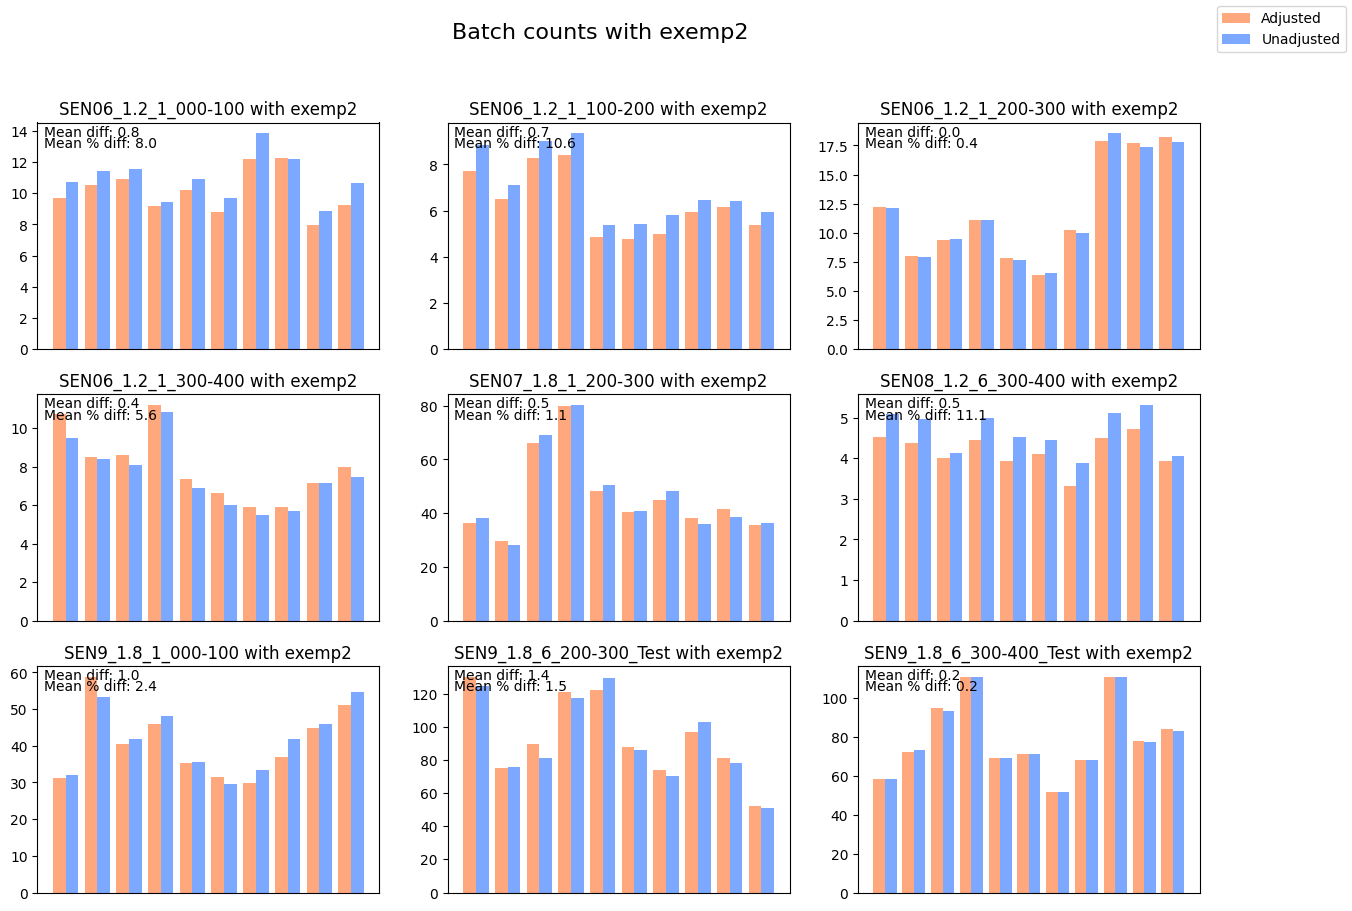

In [ ]:
df_model_grouped = df_model.groupby(['Exemplar','batch'])

batches = pd.unique(df_model['batch'])
exemplars = pd.unique(df_model['Exemplar'])
COLOURS = {"exemp1": "orange", "exemp2": "blue"}

NMSE = {}
bar_width = 0.4

for exem in exemplars:
    NMSE[exem] = {}
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    for i, batch in enumerate(batches):
        row = i // 3
        col = i % 3

        batch_data = df_model_grouped.get_group((exem, batch))
        ax = axes[row, col]

        ax.bar(batch_data['serial_num'] - bar_width/2, batch_data['counts_adj'], width = bar_width, label='Adjusted', color=(1.0, 0.6, 0.4, 0.85))
        ax.bar(batch_data['serial_num'] + bar_width/2, batch_data['counts_unadj'], width = bar_width, label='Unadjusted', color=(0.4, 0.6, 1.0, 0.85))

        adj_mean = batch_data['counts_adj'].mean()
        unadj_mean = batch_data['counts_unadj'].mean()
        mean_diff = abs(adj_mean - unadj_mean)
        mean_perc_diff = mean_diff / adj_mean
        # Calculating the normalized MSE. Normalize by dividing squared mean
        # batch_mse = (batch_data['sq_error'].sum() / adj_mean**2) * (1/batch_data.shape[0])
        # Save the Normalized MSE
        batch_nmse = get_normalized_mse(batch_data['counts_adj'], batch_data['counts_unadj'])
        NMSE[exem][batch] = batch_nmse

        ax.annotate(f'Mean diff: {mean_diff:.1f}', xy=(0.02, 0.94), xycoords='axes fraction')
        ax.annotate(f'Mean % diff: {mean_perc_diff*100:.1f}', xy=(0.02, 0.89), xycoords='axes fraction')

        ax.set_title(f"{batch} with {exem}")
        ax.set_xticks([])
        ax.set_xticklabels([])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f"Batch counts with {exem}", fontsize=16)
    plt.show()

Ovreall, the difference between using adjusted or unadjusted exemplars is not large, judging from the mean difference and percentage mean difference. Exemplar 2 seems to generalize well. The cases where the MSE is high is when there are very few bubbles in the image. While exemplar 1 is working fine except for batch 8: SEN09_1.8_6_200-300


#### 2.2.2 Plotting the Normalized MSE
This shows how consistent the exemplars perform across the batchs

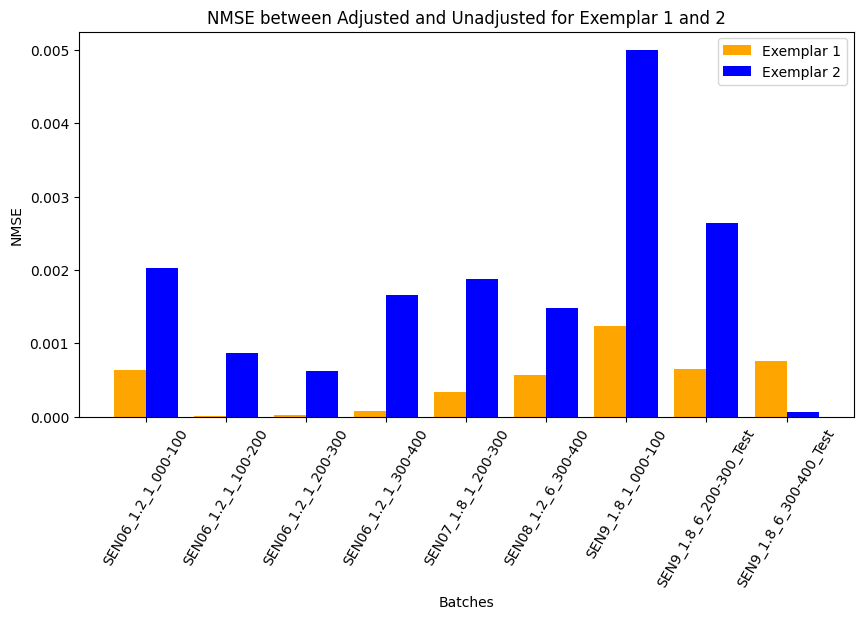

In [ ]:
exemp1_data = NMSE['exemp1']
exemp2_data = NMSE['exemp2']
batches = list(exemp1_data.keys())  # Assuming both exemplars have the same batch names

# Create a bar chart for both exemplars side by side
bar_width = 0.4
index = np.arange(len(batches))

plt.figure(figsize=(10, 5))
plt.bar(index, [exemp1_data[batch] for batch in batches], bar_width, label='Exemplar 1', color='orange')
plt.bar(index + bar_width, [exemp2_data[batch] for batch in batches], bar_width, label='Exemplar 2', color='blue')

plt.title('NMSE between Adjusted and Unadjusted for Exemplar 1 and 2')
plt.xlabel('Batches')
plt.ylabel('NMSE')
plt.xticks(index + bar_width / 2, batches, rotation=60)
plt.legend()
plt.show()


Using exemplar 1, the adjusted and unadjusted has even less difference.

### 2.3 Set4 vs. set6

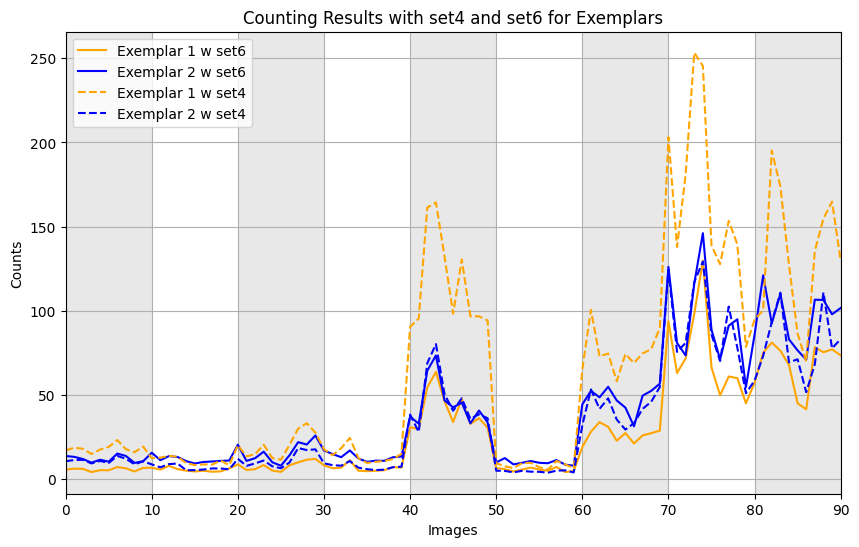

In [ ]:
# Plotting set4 with set6
exemplar_1 = df_model[df_model['Exemplar'] == 'exemp1']
exemplar_2 = df_model[df_model['Exemplar'] == 'exemp2']

plt.figure(figsize=(10, 6))
plt.plot(exemplar_1.index, exemplar_1['counts_set6'], label='Exemplar 1 w set6', color='orange', linestyle='-')
plt.plot(exemplar_2.index - 91, exemplar_2['counts_set6'], label='Exemplar 2 w set6', color='blue', linestyle='-')
plt.plot(exemplar_1.index, exemplar_1['counts_unadj'], label='Exemplar 1 w set4', color='orange', linestyle='--')
plt.plot(exemplar_2.index - 91, exemplar_2['counts_unadj'], label='Exemplar 2 w set4', color='blue', linestyle='--')


plt.xlabel('Images')
plt.ylabel('Counts')
plt.title(f'Counting Results with set4 and set6 for Exemplars')
plt.grid(True)

for i in range(0, len(exemplar_1), 10):
    if i // 10 % 2 == 0:
        plt.axvspan(i, i + 10, facecolor='lightgray', alpha=0.5)
    else:
        plt.axvspan(i, i + 10, facecolor='white')

plt.xlim(0, 90)
plt.legend()
plt.show()

The 6 exemplars from Sample image 2 seems to be more reliable. While, overall, the bias seems to be consistent still.

### 2.4 Quality Across Batches (Comparing Model and Manual)
Using only the set6 unadjusted data, since the unadjusted is quite similar to it and set 6 seems to be more stable.

In [ ]:
df_manual.head()

,batch,serial_num,Counts
0,SEN06_1.2_1_000-100,0,18
1,SEN06_1.2_1_000-100,1,15
2,SEN06_1.2_1_000-100,2,18
3,SEN06_1.2_1_000-100,3,17
4,SEN06_1.2_1_000-100,4,13


In [ ]:
df_model

,Exemplar,batch,serial_num,counts_adj,counts_unadj,counts_set6,sq_error
0,exemp1,SEN06_1.2_1_000-100,0,17.453785,17.111538,5.745326,0.117133
1,exemp1,SEN06_1.2_1_000-100,1,18.348644,18.765196,6.301402,0.173515
2,exemp1,SEN06_1.2_1_000-100,2,17.995039,18.095247,6.201206,0.010042
3,exemp1,SEN06_1.2_1_000-100,3,14.698973,15.033589,4.294728,0.111968
4,exemp1,SEN06_1.2_1_000-100,4,17.123608,17.624695,5.394546,0.251088
...,...,...,...,...,...,...,...
177,exemp2,SEN9_1.8_6_300-400_Test,7,51.558331,51.692291,71.025391,0.017945
178,exemp2,SEN9_1.8_6_300-400_Test,8,68.084488,68.269638,106.618057,0.034281
179,exemp2,SEN9_1.8_6_300-400_Test,9,111.098137,110.932068,106.434601,0.027579
180,exemp2,SEN9_1.8_6_300-400_Test,10,78.253174,77.733200,97.961205,0.270373


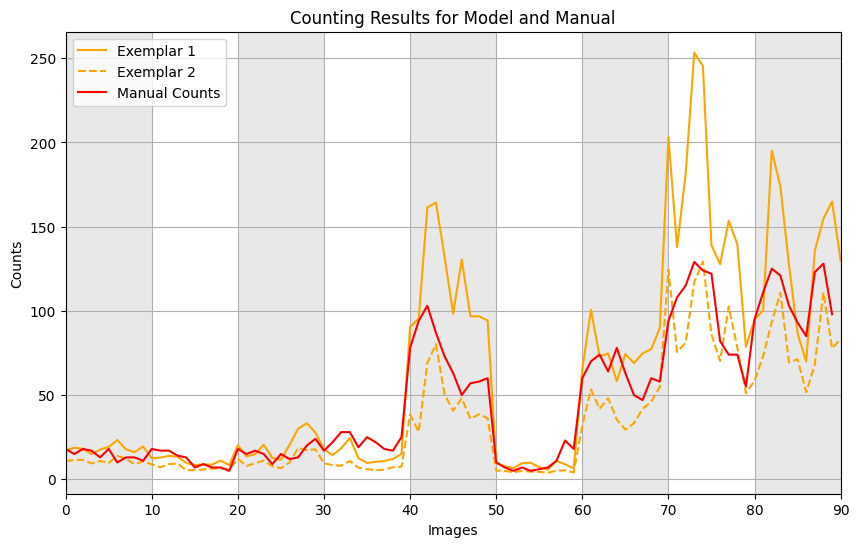

In [ ]:
# Ploting unadjusted and manual counts together

# Including two exemplars
exemplar_1 = df_model[df_model['Exemplar'] == 'exemp1']
exemplar_2 = df_model[df_model['Exemplar'] == 'exemp2']

plt.figure(figsize=(10, 6))
plt.plot(exemplar_1.index, exemplar_1['counts_unadj'], label='Exemplar 1', color='orange', linestyle='-')
plt.plot(exemplar_2.index-91, exemplar_2['counts_unadj'], label='Exemplar 2', color='orange', linestyle='--')
plt.plot(df_manual.index, df_manual["Counts"], label='Manual Counts', color="red")


plt.xlabel('Images')
plt.ylabel('Counts')
plt.title(f'Counting Results for Model and Manual')
plt.grid(True)

for i in range(0, len(exemplar_1), 10):
    if i // 10 % 2 == 0:
        plt.axvspan(i, i + 10, facecolor='lightgray', alpha=0.5)
    else:
        plt.axvspan(i, i + 10, facecolor='white')

plt.xlim(0, 90)
plt.legend()
plt.show()

Looking at this graph, the model counts are not way off from the model counts. Might be ok with proceed with this counting model.

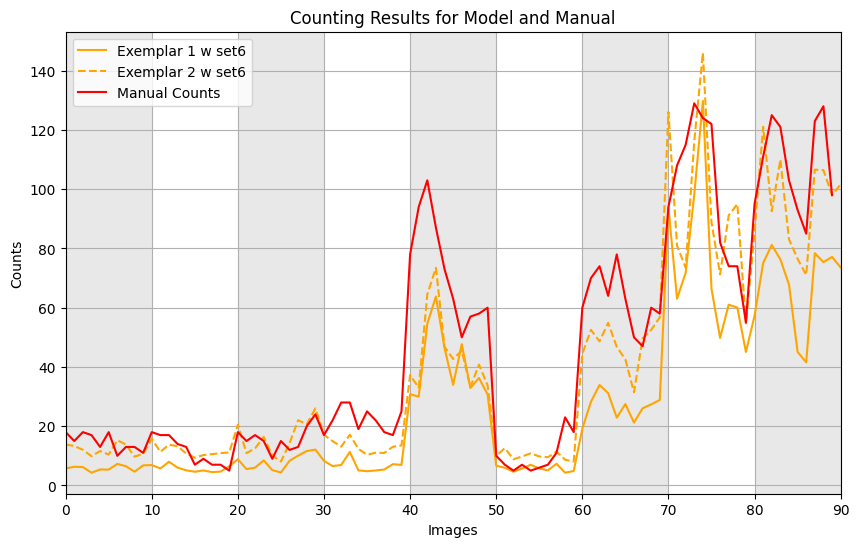

In [ ]:
# Plotting set6 with Manual
exemplar_1 = df_model[df_model['Exemplar'] == 'exemp1']
exemplar_2 = df_model[df_model['Exemplar'] == 'exemp2']

plt.figure(figsize=(10, 6))
plt.plot(exemplar_1.index, exemplar_1['counts_set6'], label='Exemplar 1 w set6', color='orange', linestyle='-')
plt.plot(exemplar_2.index - 91, exemplar_2['counts_set6'], label='Exemplar 2 w set6', color='orange', linestyle='--')
plt.plot(df_manual.index, df_manual["Counts"], label='Manual Counts', color="red")


plt.xlabel('Images')
plt.ylabel('Counts')
plt.title(f'Counting Results for Model and Manual')
plt.grid(True)

for i in range(0, len(exemplar_1), 10):
    if i // 10 % 2 == 0:
        plt.axvspan(i, i + 10, facecolor='lightgray', alpha=0.5)
    else:
        plt.axvspan(i, i + 10, facecolor='white')

plt.xlim(0, 90)
plt.legend()
plt.show()

Looks still fine with the manual counts, since it is similar to using exemplar 2.

In [ ]:
df_model_grouped = df_model.groupby(['Exemplar','batch'])
df_manual_grouped = df_manual.groupby(['batch'])

batches = pd.unique(df_model['batch'])
exemplars = pd.unique(df_model['Exemplar'])

nmse_list = []

for i, batch in enumerate(batches):
    batch_exemp1 = df_model_grouped.get_group(('exemp1', batch))
    batch_exemp2 = df_model_grouped.get_group(('exemp2', batch))
    batch_manual = df_manual_grouped.get_group((batch))

    batch_name = batch_exemp1['batch'].unique()[0]
    nmse_exemp1 = get_normalized_mse(batch_exemp1["counts_set6"], batch_manual["Counts"])
    nmse_exemp2 = get_normalized_mse(batch_exemp2["counts_set6"], batch_manual["Counts"])
    nmse_list.append({"Batch": batch_name, "NMSE_1": nmse_exemp1, "NMSE_2": nmse_exemp2})

nmse_results = pd.DataFrame(nmse_list)

#### 2.4.1 Normalized Mean Square Error (NMSE) of Set6 vs. Manual

The manual counts used for this experiment (9_batches) is much poorer compared to the previous experiemnt (1_batch). The manual counts of the 90 images were taken from the author alone which means it is subject to huge mistakes and in-the-moment biases. Therefore, the following NMSE values should be examined with this context in mind.

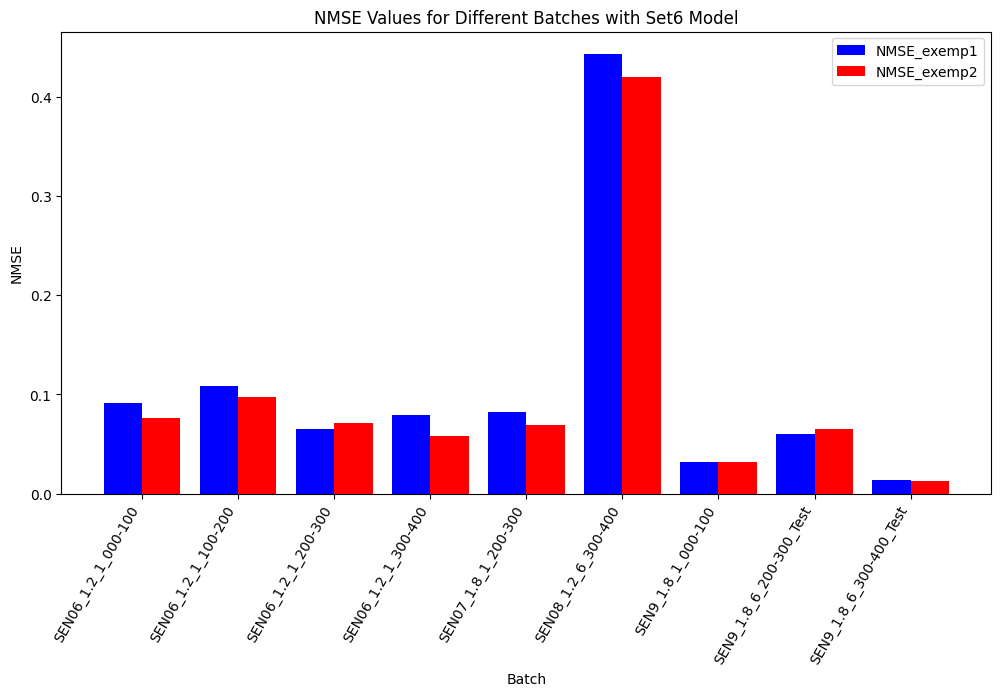

In [ ]:
x = range(len(nmse_results))

plt.figure(figsize=(12, 6))
# Plot the 'NMSE_1' and 'NMSE_2' values as blue bars
plt.bar([i - 0.2 for i in x], nmse_results['NMSE_1'], width=0.4, label='NMSE_exemp1', color='b')
plt.bar([i + 0.2 for i in x], nmse_results['NMSE_2'], width=0.4, label='NMSE_exemp2', color='r')

plt.xticks(x, nmse_results['Batch'], rotation=60, ha='right')
plt.xlabel('Batch')
plt.ylabel('NMSE')
plt.title('NMSE Values for Different Batches with Set6 Model')
plt.legend()

The batch SEN08_1.2_6_300-400 seems to have the worst of it. Further examining it in the next section.

#### 2.4.2 Plotting batch by batch

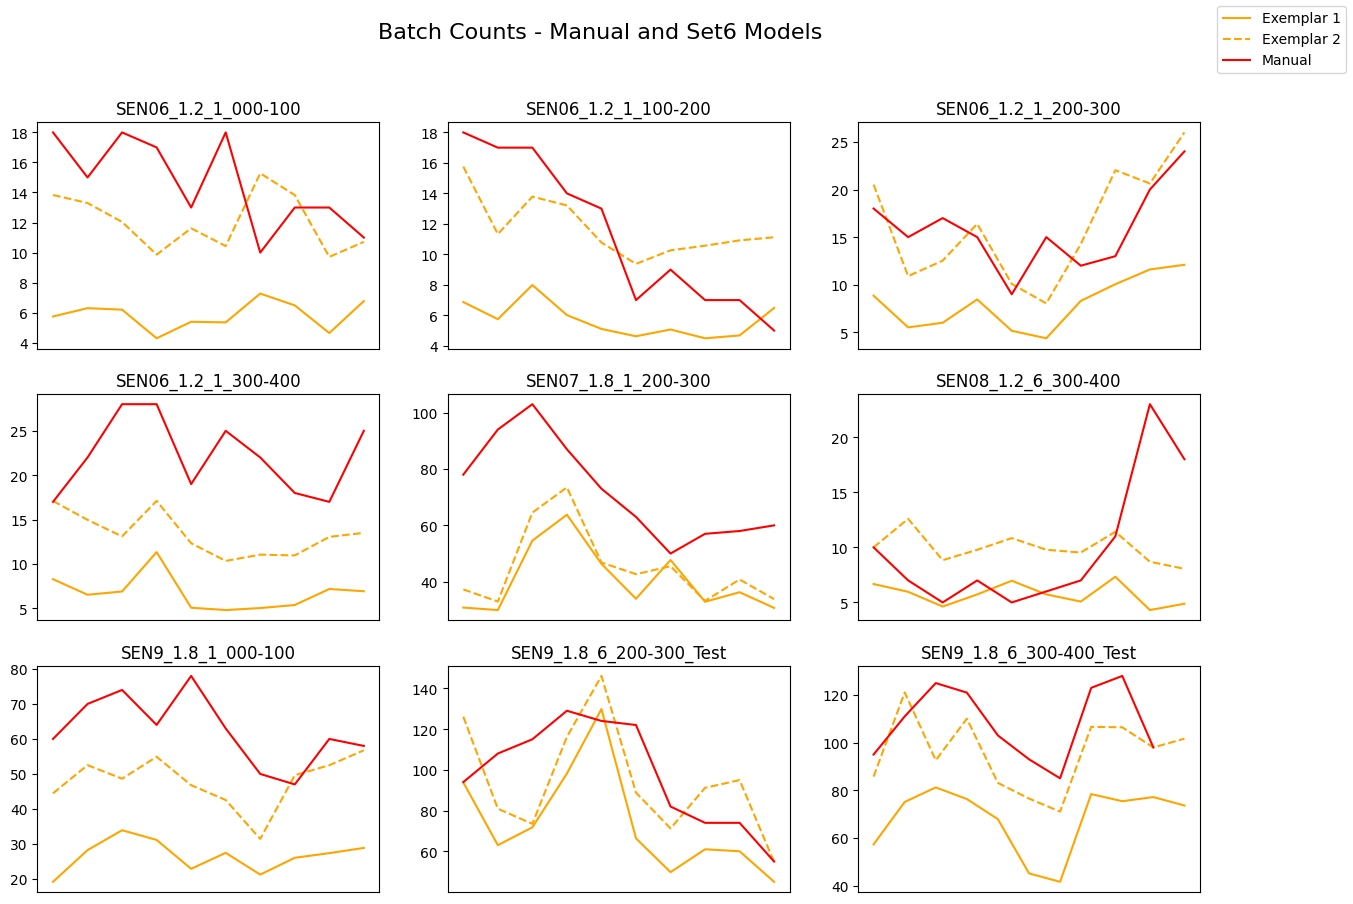

In [ ]:
df_model_grouped = df_model.groupby(['Exemplar','batch'])
df_manual_grouped = df_manual.groupby(['batch'])

batches = pd.unique(df_model['batch'])
exemplars = pd.unique(df_model['Exemplar'])

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, batch in enumerate(batches):
    row = i // 3
    col = i % 3

    batch_exemp1 = df_model_grouped.get_group(('exemp1', batch))
    batch_exemp2 = df_model_grouped.get_group(('exemp2', batch))
    batch_manual = df_manual_grouped.get_group((batch))
    ax = axes[row, col]

    ax.plot(batch_exemp1['serial_num'], batch_exemp1['counts_set6'], label='Exemplar 1', color='orange', linestyle="-")
    ax.plot(batch_exemp2['serial_num'], batch_exemp2['counts_set6'], label='Exemplar 2', color='orange', linestyle='--')
    ax.plot(batch_manual['serial_num'], batch_manual['Counts'], label="Manual", color="red")

    ax.set_title(f"{batch}")
    ax.set_xticks([])
    ax.set_xticklabels([])

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"Batch Counts - Manual and Set6 Models", fontsize=16)
plt.show()

From above, I am happy with the model counts. of all 90 points, there are only about 2 that I thought are way off. The batch SEN08_1.2_6_300-400 giving the worst NMSE is caused by one of these outliers. It is nothing to be alarmed. While the rest of the batches, from both quantitative and qualitative perspectives, shows that the models are giving reasonable counts with consistent biases.

## Part 3 - Diving into the Images

From the results in 2.2, I want to investigate the following:
- Look at the two exemplar images and bounding boxes, see if it's obvious why 2 is better than 1
- Look at batch 7 and see if it seems much different than Exemplar 1 or the others.

#### 3.1 Comparing the exemplars used

In [ ]:
# Looking at the exemplars
def draw_rectangles_on_image(image_path, coordinates_file):
    # Open the image
    image = Image.open(image_path)

    # Open the coordinates file
    with open(coordinates_file, 'r') as file:
        lines = file.readlines()

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Process each line in the coordinates file
    for line in lines:
        y1, x1, y2, x2 = map(int, line.strip().split())
        draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

    display(image)

Showing Exemplar 1:


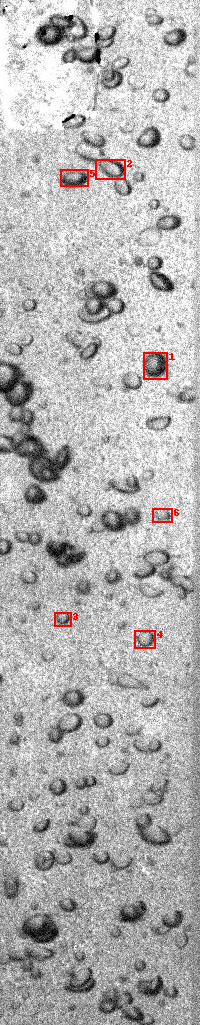

Showing Exemplar 2:


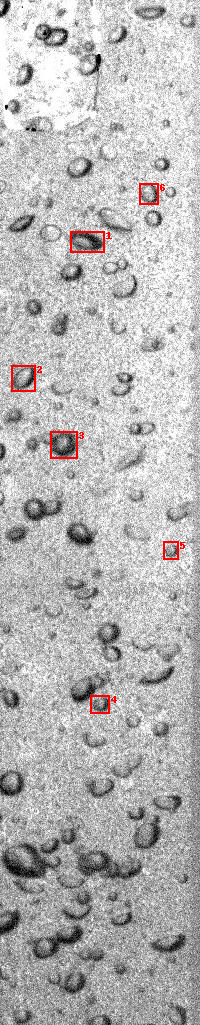

In [ ]:
print("Showing Exemplar 1:")
image_preprocess.draw_rectangles_on_image('Exemplars/exemp1.jpg', 'Exemplars/exemp1_box.txt')

print("Showing Exemplar 2:")
image_preprocess.draw_rectangles_on_image('Exemplars/exemp2.jpg', 'Exemplars/exemp2_box.txt')

No obvious patterns, really. Both sets exemplars are chosen to represent a variety of bubbles.

#### 3.2 Display the Images of each batch

In [ ]:
def display_batch_images(directory):
    batch_count = 0
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    fig.suptitle("Sample Images from 9 Batches")
    for root, _, files in os.walk(directory):
        if not "patch_coord.txt" in files:
            # Just one of the ways to make sure we are in the batch folder
            continue
        batch_count += 1
        for file in files:
            if not file.endswith(".jpg"):
                continue
            batch_name, _ = get_batch_and_serial(file)

            image_path = os.path.join(root, file)
            image = Image.open(image_path)

            ax = axes[batch_count//3 - 1, batch_count%3 -1]
            ax.imshow(image)
            ax.axis('off')
            ax.set_title(batch_name)
            break

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

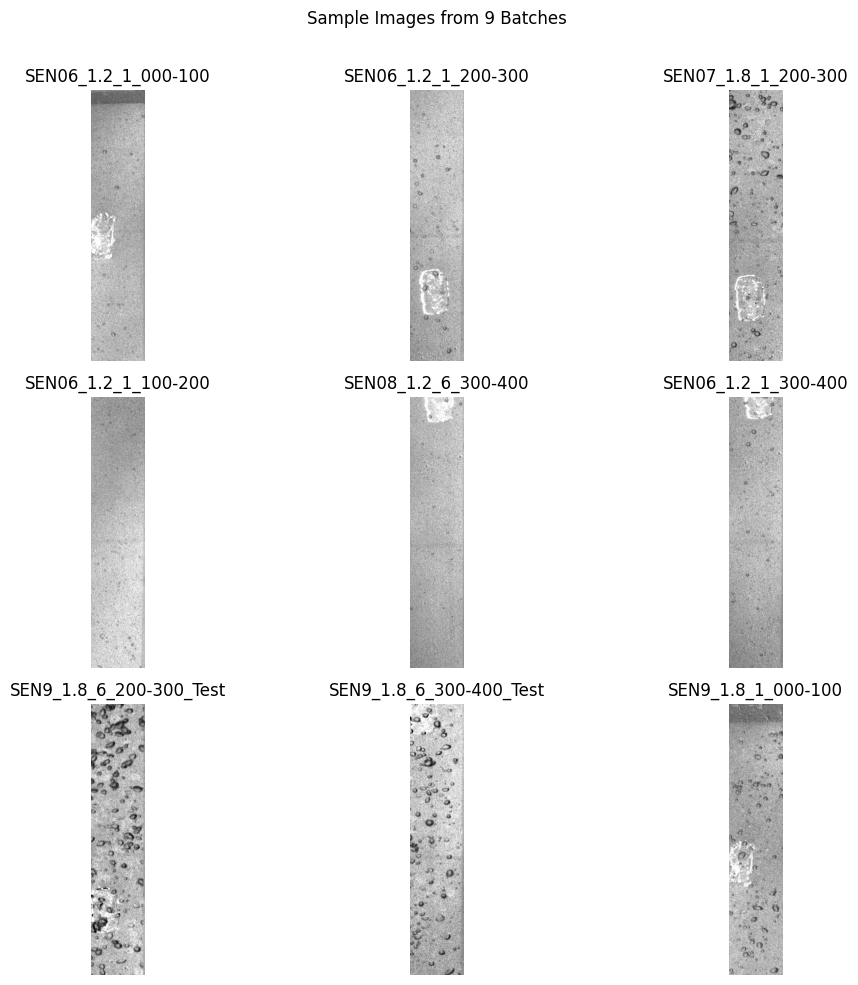

In [ ]:
target_path = "Targets/9_batch/"
display_batch_images(target_path)

Variety of batches are involved in this dummy example.

SEN09_1.8_6_200-300 is the batch where using exemplar 1 has the most differences for when adjusted and unadjusted. The bubbles seem to be darker and more "smudged". But unsure how to interpret this.